In [1]:
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [2]:
x_MainFoil, y_MainFoil = numpy.loadtxt('MainFoil_N=100.csv', delimiter=',', unpack=True)
x_FlapFoil, y_FlapFoil = numpy.loadtxt('FlapFoil_N=100.csv', delimiter=',', unpack=True)

In [3]:
COLUMN = numpy.concatenate((x_MainFoil, x_FlapFoil), axis=0)

(-0.25, 0.2)

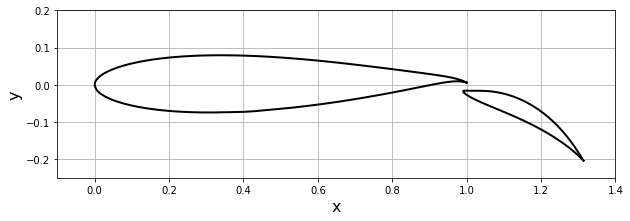

In [4]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_MainFoil, y_MainFoil, x_FlapFoil, y_FlapFoil, color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.25, 0.2)

MAINFOIL PANEL CLASS

In [5]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  
        self.length = math.sqrt((xb - xa)**2 + (yb - ya)**2)  
        
        if xb - xa <= 0.:
            self.beta = math.acos((yb - ya) / self.length)
        elif xb - xa > 0.:
            self.beta = math.pi + math.acos(-(yb - ya) / self.length)
        
        if self.beta <= numpy.pi:
            self.loc = 'upper'  
        else:
            self.loc = 'lower'  
 
        self.sigma = 0.0  
        self.vt = 0.0  
        self.cp = 0.0 

In [6]:
x_ends = x_MainFoil
y_ends = y_MainFoil

N = 100
panels = numpy.empty(N, dtype=object)
for i in range(N):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])

FLAPFOIL PANEL CLASS

In [7]:
x_ends2 = x_FlapFoil
y_ends2 = y_FlapFoil

N = 100
panels_fp = numpy.empty(N, dtype=object)
for i in range(N):
    panels_fp[i] = Panel(x_ends2[i], y_ends2[i], x_ends2[i + 1], y_ends2[i + 1])

FREESTREAM CLASS

In [8]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)

In [9]:
u_inf = 1.0
alpha = 0.0
freestream = Freestream(u_inf, alpha)

GETTING SIGMA AND GAMMA

In [10]:
def integral(x, y, panel, dxdz, dydz):
    def integrand(s):
        return (((x - (panel.xa - math.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + math.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - math.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + math.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [11]:
def source_contribution_normal(panels, panels_fp):
    A = numpy.empty((panels.size + panels_fp.size, panels.size + panels_fp.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels_fp):
            A[i, 100 + j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    
    for i, panel_i in enumerate(panels_fp):
        for j, panel_j in enumerate(panels):
            A[i + 100, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    
    for i, panel_i in enumerate(panels_fp):
        for j, panel_j in enumerate(panels_fp):
            if i != j:
                A[i + 100, j + 100] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    
    return A

In [12]:
def vortex_contribution_normal(panels, panels_fp):
    A = numpy.empty((panels.size + panels_fp.size, panels.size + panels_fp.size), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels_fp):
            A[i, 100 + j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    
    for i, panel_i in enumerate(panels_fp):
        for j, panel_j in enumerate(panels):
            A[i + 100, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    
    for i, panel_i in enumerate(panels_fp):
        for j, panel_j in enumerate(panels_fp):
            if i != j:
                A[i + 100, j + 100] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

In [13]:
A_source = source_contribution_normal(panels, panels_fp)
B_vortex = vortex_contribution_normal(panels, panels_fp)

Accessory matrix

In [14]:
def build_b_matrix(panels, panels_fp, freestream):
    A = numpy.empty(panels.size + panels_fp.size, dtype=float)
    for i, panel in enumerate(panels):
        A[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    for j, panel in enumerate(panels_fp):
        A[100 + j] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    return A

In [15]:
b_b = build_b_matrix(panels, panels_fp, freestream)

In [16]:
b_b.shape

(200,)

In [17]:
def build_B_matrix(B_vortex):
    A = numpy.empty((A_source.shape[0], 2), dtype=float)
    A[:-100, 0] = numpy.sum(B_vortex[:-100, :-100], axis=1)
    A[:-100, 1] = numpy.sum(B_vortex[:-100, 100:], axis=1)
    A[100:, 0] = numpy.sum(B_vortex[100:, :-100], axis=1)
    A[100:, 1] = numpy.sum(B_vortex[100:, 100:], axis=1)
    return A

In [18]:
B_B = build_B_matrix(B_vortex)

Building linear system

In [19]:
def kutta_condition(A_source, B_vortex):
    b = numpy.empty((2, A_source.shape[1] + 2), dtype=float)
    b[0, :-2] = B_vortex[0, :] + B_vortex[99, :]
    b[1, :-2] = B_vortex[100, :] + B_vortex[-1, :]
    b[0, -2] = - numpy.sum(A_source[0, :-100] + A_source[99, :-100])
    b[0, -1] = - numpy.sum(A_source[0, 100:] + A_source[99, 100:])
    b[1, -2] = - numpy.sum(A_source[100, :-100] + A_source[-1, :-100])
    b[1, -1] = - numpy.sum(A_source[100, 100:] + A_source[-1, 100:])
    return b

In [20]:
def build_singularity_matrix(A_source, B_vortex, B_B):
    A = numpy.empty((A_source.shape[0] + 2, A_source.shape[1] + 2), dtype=float)
    A[:-2, :-2] = A_source
    A[:-2, 200:] = B_B
    A[200:, :] = kutta_condition(A_source, B_vortex)
    return A

In [21]:
def build_freestream_rhs(panels, panels_fp, freestream, b_b):
    b = numpy.empty((panels.size + panels_fp.size + 2), dtype=float)
    b[:-2] = b_b
    b[-2] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels_fp[0].beta) +
                                 numpy.sin(freestream.alpha - panels_fp[-1].beta) )
    return b

In [22]:
A = build_singularity_matrix(A_source, B_vortex, B_B)
b = build_freestream_rhs(panels, panels_fp, freestream, b_b)

In [23]:
strengths = numpy.linalg.solve(A, b)

In [24]:
b.shape

(202,)

In [25]:
strengths[-2]

0.67278867959335875

In [26]:
for i, panel in enumerate(panels):
    panel.sigma = strengths[i]
for j, panel in enumerate(panels_fp):
    panel.sigma = strengths[100 + j]
    

gamma_main = strengths[-2]
gamma_flap = strengths[-1]

Surface pressure coefficient

In [27]:
def build_tangential_velocity_matrix(panels, panels_fp, A_source, B_vortex):
    A = numpy.empty((panels.size + panels_fp.size, panels.size + panels_fp.size + 2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:, :-100], axis=1)
    A[:, -1] = -numpy.sum(A_source[:, 100:], axis=1)
    return A

In [28]:
def build_freestream_tangential_velocity_rhs(panels, panels_fp, freestream):
    b = numpy.empty(panels.size + panels_fp.size, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = freestream.u_inf * numpy.sin(freestream.alpha - panel.beta)
    for j, panel in enumerate(panels_fp):
        b[100 + j] = freestream.u_inf * numpy.sin(freestream.alpha - panel.beta)
    return b

In [29]:
A_vt = build_tangential_velocity_matrix(panels, panels_fp, A_source, B_vortex)
b_vt = build_freestream_tangential_velocity_rhs(panels, panels_fp, freestream)

In [30]:
tangential_velocities = numpy.dot(A_vt, strengths) + b_vt
    
for i, panel in enumerate(panels):
    panel.vt = tangential_velocities[i]
for j, panel in enumerate(panels_fp):
    panel.vt = tangential_velocities[100 + j]

In [31]:
for i, panel in enumerate(panels):
    panel.cp = 1.0 - (tangential_velocities[i] / freestream.u_inf)**2
for j, panel in enumerate(panels_fp):
    panel.cp = 1.0 - (tangential_velocities[100 + j] / freestream.u_inf)**2

In [32]:
accuracy = sum([panel.sigma * panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.000387


In [33]:
accuracy = sum([panel.sigma * panel.length for panel in panels_fp])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: -0.002136


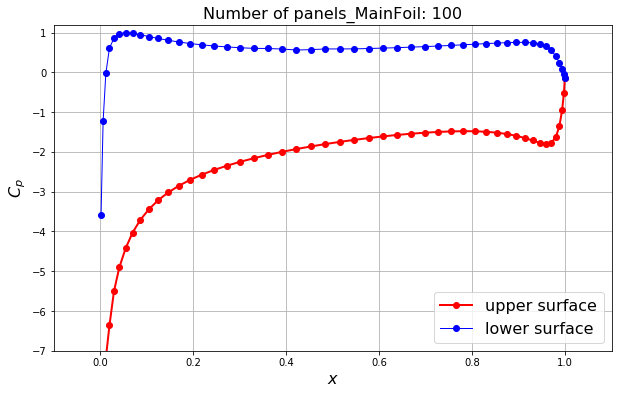

In [34]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-7.0, 1.2)
pyplot.title('Number of panels_MainFoil: {}'.format(panels.size), fontsize=16);

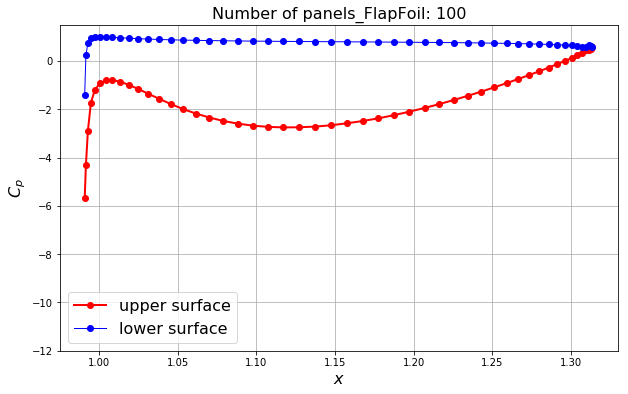

In [35]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels_fp if panel.loc == 'upper'],
            [panel.cp for panel in panels_fp if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels_fp if panel.loc == 'lower'],
            [panel.cp for panel in panels_fp if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(0.975, 1.33)
pyplot.ylim(-12.0, 1.5)
pyplot.title('Number of panels_FlapFoil: {}'.format(panels.size), fontsize=16)

In [36]:
panels[2].cp

-0.95570117298078339

In [37]:
panels_fp[9].cp

-0.2799183983685587

In [38]:
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma_main * sum(panel.length for panel in panels) /
      (0.5 * freestream.u_inf * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 2.767


In [39]:
c2 = abs(max(panel.xa for panel in panels_fp) -
        min(panel.xa for panel in panels_fp))
cl2 = (gamma_flap * sum(panel.length for panel in panels_fp) /
      (0.5 * freestream.u_inf * c2))
print('lift coefficient: CL2 = {:0.3f}'.format(cl2))

lift coefficient: CL2 = 2.960


In [40]:
L = c * cl + c2 * cl2
print(L)

3.7240537583
